Importamos las librerías a utilizar, deberían ya estar instaladas en el entorno virtual, así que este .ipynb no incluirá su instalación con pip.

In [224]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

Cargamos los datos del censo con la librería Pandas, y los datos geoespaciales en formato shapefile con GeoPandas.

In [225]:
df_censo = pd.read_csv('Censo2017_Manzanas.csv', sep=';', low_memory=False)

gdf_comunas = gpd.read_file('R13/COMUNA_C17.shp') # Los shapefiles están en el directorio R13.

In [226]:
df_censo.info()
print("---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----")
gdf_comunas.info()
print("---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----")
print("DF Censo head:")
df_censo.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180499 entries, 0 to 180498
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   REGION          180499 non-null  int64 
 1   PROVINCIA       180499 non-null  int64 
 2   COMUNA          180499 non-null  int64 
 3   DC              180499 non-null  int64 
 4   AREA            180499 non-null  int64 
 5   ZC_LOC          180499 non-null  int64 
 6   MZ_ENT          180499 non-null  int64 
 7   ID_ZONA_LOC     180499 non-null  int64 
 8   ID_MANZENT      180499 non-null  int64 
 9   PERSONAS        180499 non-null  int64 
 10  HOMBRES         180499 non-null  object
 11  MUJERES         180499 non-null  object
 12  EDAD_0A5        180499 non-null  object
 13  EDAD_6A14       180499 non-null  object
 14  EDAD_15A64      180499 non-null  object
 15  EDAD_65YMAS     180499 non-null  object
 16  INMIGRANTES     180499 non-null  object
 17  PUEBLO          180499 non-nu

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,MZ_ENT,ID_ZONA_LOC,ID_MANZENT,PERSONAS,...,MATREC,MATIRREC,P05_1,P05_2,P05_3,P05_4,REGION_15R,PROVINCIA_15R,COMUNA_15R,ID_MANZENT_15R
0,1,11,1101,1,1,1,1,7849,1101011001001,15,...,0,0,0,0,0,0,1,11,1101,1101011001001
1,1,11,1101,1,1,1,10,7849,1101011001010,70,...,1,0,15,0,0,0,1,11,1101,1101011001010
2,1,11,1101,1,1,1,11,7849,1101011001011,36,...,5,0,15,0,0,0,1,11,1101,1101011001011
3,1,11,1101,1,1,1,12,7849,1101011001012,65,...,9,4,24,0,0,0,1,11,1101,1101011001012
4,1,11,1101,1,1,1,13,7849,1101011001013,39,...,0,0,9,0,0,0,1,11,1101,1101011001013


Miramos información sobre los datos, y luego hacemos una limpieza de datos nulos, y también verificamos que el tipo de dato sea el correcto.

In [227]:
# coerce pondrá NaN donde hay valores no válidos, que luego rellenamos con 0 mediante el método .fillna(0)
df_censo['PERSONAS'] = pd.to_numeric(df_censo['PERSONAS'], errors='coerce').fillna(0)

df_censo = df_censo[df_censo['REGION'] == 13] # Nos interesa únicamente la región 13, que es la región metropolitana (Santiago)

# Hacemos un agregado de personas por cada comuna, lo que sumará las personas en cada comuna.
poblacion_por_comuna = df_censo.groupby('COMUNA')['PERSONAS'].sum().reset_index() # reset_index para crear un nuevo DF
poblacion_por_comuna.rename(columns={'PERSONAS': 'POBLACION_TOTAL_COMUNA'}, inplace=True)
print(poblacion_por_comuna.head())

# Para hacer un merge del DF de las poblaciones en cada comuna con el GDF de los shapefiles, necesitamos
# llevar las columnas a mergear con el mismo tipo de dato, en este caso llevamos ambas a str:
poblacion_por_comuna['COMUNA'] = poblacion_por_comuna['COMUNA'].astype(str)
gdf_comunas['COMUNA'] = gdf_comunas['COMUNA'].astype(str)

# Hacemos el merge en left, para que se consideren todas las comunas del GDF, en caso de no existir
# coincidencias en el DF del censo apra esa comuna, el merge contendrá una columna de NaN.
gdf_merged = gdf_comunas.merge(poblacion_por_comuna, on='COMUNA', how='left')
gdf_merged['POBLACION_TOTAL_COMUNA'] = gdf_merged['POBLACION_TOTAL_COMUNA'].fillna(0) # Rellenamos cualquier nulo con ceros.

   COMUNA  POBLACION_TOTAL_COMUNA
0   13101                  404495
1   13102                   80832
2   13103                  132622
3   13104                  126955
4   13105                  162505


Ahora mostramos las visualizaciones con matplotlib.

Usamos https://matplotlib.org/stable/users/explain/colors/colormaps.html para elegir el gradiente de colores a representar.

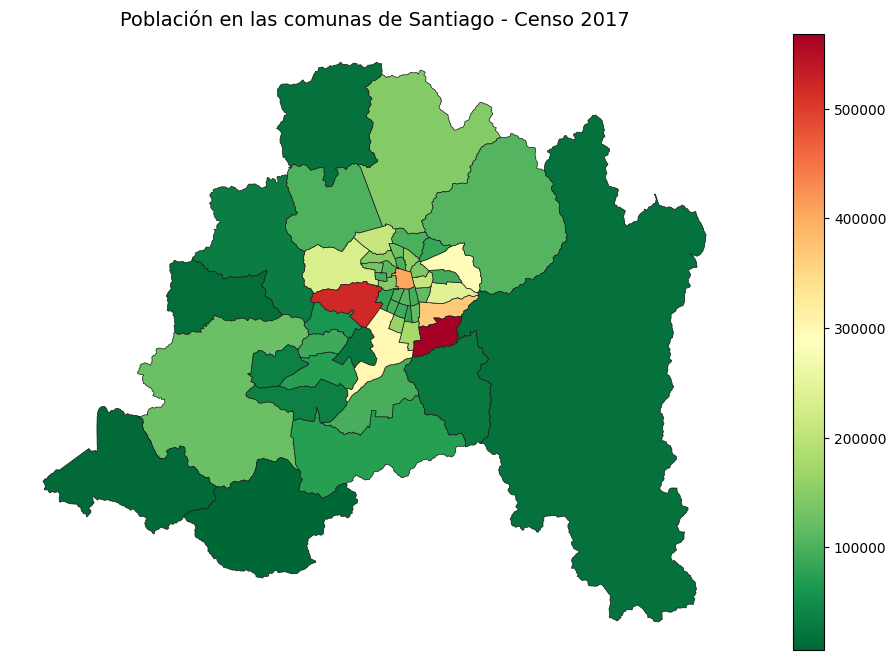

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8)) # No usarmos el objeto fig.

gdf_merged.plot(
    column='POBLACION_TOTAL_COMUNA',
    cmap='RdYlGn_r',
    linewidth=.5, # Borde de las comunas
    ax=ax,
    edgecolor='.1', # Intensidad del color del borde
    legend=True
)

ax.set_title('Población en las comunas de Santiago - Censo 2017', fontsize=14)
ax.set_axis_off() # Le quitamos los axis de coordenadas provenientes del GDF para que se vea más limpio
plt.savefig('mapa_poblacion_santiago.png') # Guardamos el mapa en un .png
plt.show()

Adicionalmente, mostramos una visualización de la cantidad de adultos mayores (+65 años) por cada comuna de Santiago.

In [229]:
# Igual que antes, cambiamos el tipo de dato de la columna, en este caso con el método .to_numeric de la librería
# Pandas, y luego los posibles errores que entregan NaN los rellenamos con ceros, para evitar errores.
df_censo['EDAD_65YMAS'] = pd.to_numeric(df_censo['EDAD_65YMAS'], errors='coerce').fillna(0)

# Agrupamos como antes, pero para la cantidad de adultos de la tercera edad por cada comuna.
adultos_mayores_df = df_censo.groupby('COMUNA')['EDAD_65YMAS'].sum().reset_index()
print(adultos_mayores_df.head()) # Comprobamos los datos.
adultos_mayores_df['COMUNA'] = adultos_mayores_df['COMUNA'].astype(str)

# Hacemos el merge en left, para que se consideren todas las comunas del GDF, en caso de no existir
# coincidencias en el DF del censo apra esa comuna, el merge contendrá una columna de NaN.
gdf_merged = gdf_merged.merge(adultos_mayores_df, on='COMUNA', how='left')
gdf_merged['EDAD_65YMAS'] = gdf_merged['EDAD_65YMAS'].fillna(0)

   COMUNA  EDAD_65YMAS
0   13101      28936.0
1   13102       9273.0
2   13103      16011.0
3   13104      16819.0
4   13105      19321.0


Visualizamos

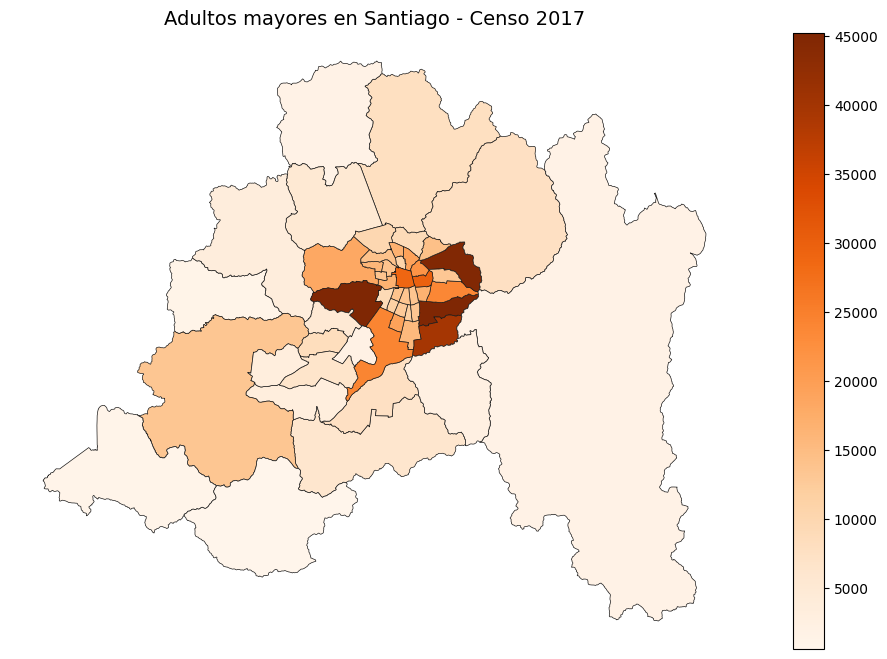

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
gdf_merged.plot(
    column='EDAD_65YMAS',
    cmap='Oranges',
    linewidth=0.5, # Borde de las comunas
    ax=ax,
    edgecolor='.1', # Intensidad del color del borde
    legend=True
)
ax.set_title('Adultos mayores en Santiago - Censo 2017', fontsize=14)
ax.set_axis_off()
plt.savefig('mapa_poblacion_adultos_mayores_santiago.png') # Guardamos el mapa en un .png
plt.show()

Al parecer, los shapefiles sólo incluían las comunas de Santiago en la región metropolitana, por lo que no era necesario el filtrado que hice por la región 13, pero no afecta en nada ya que el merge del DataFrame con el GeoDataFrame se ha realizado con how='left', por lo que no tomará en cuenta los datos que están en el DF del censo pero no en el GDF de Santiago.